# TreeBoxes

In this notebook, we illustrate the structure of the datasets and performance of the baseline box model against the official training split.

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch

if os.path.basename(os.getcwd()) == 'examples':
    sys.path.append("../")
    
import milliontrees

We will use the DeepForest bounding box model available at https://deepforest.readthedocs.io/en/v1.4.1/user_guide/02_prebuilt.html#tree-crown-detection-model

In [2]:
from deepforest import main
m = main.deepforest()
m.load_model("weecology/deepforest-tree")

/blue/ewhite/b.weinstein/miniconda3/envs/MillionTrees/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/blue/ewhite/b.weinstein/miniconda3/envs/MillionTrees/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 2.0.0 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Reading config file: /blue/ewhite/b.weinstein/miniconda3/envs/MillionTrees/lib/python3.10/site-packages/deepforest/data/deepforest_config.yml


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Reading config file: /blue/ewhite/b.weinstein/miniconda3/envs/MillionTrees/lib/python3.10/site-packages/deepforest/data/deepforest_config.yml


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


     xmin   ymin   xmax   ymax label     score    image_path  \
0   330.0  342.0  373.0  391.0  Tree  0.802979  OSBS_029.png   
1   216.0  206.0  248.0  242.0  Tree  0.778803  OSBS_029.png   
2   325.0   44.0  363.0   82.0  Tree  0.751572  OSBS_029.png   
3   261.0  238.0  296.0  276.0  Tree  0.748605  OSBS_029.png   
4   173.0    0.0  229.0   33.0  Tree  0.738210  OSBS_029.png   
5   258.0  198.0  291.0  230.0  Tree  0.716250  OSBS_029.png   
6    97.0  305.0  152.0  363.0  Tree  0.711665  OSBS_029.png   
7    52.0   72.0   85.0  108.0  Tree  0.698782  OSBS_029.png   
8   292.0  368.0  332.0  400.0  Tree  0.688486  OSBS_029.png   
9   249.0   51.0  277.0   81.0  Tree  0.688165  OSBS_029.png   
10  317.0  181.0  345.0  210.0  Tree  0.686540  OSBS_029.png   
11   18.0  346.0   57.0  388.0  Tree  0.668806  OSBS_029.png   
12  272.0  330.0  305.0  367.0  Tree  0.666737  OSBS_029.png   
13  277.0    0.0  311.0   31.0  Tree  0.654230  OSBS_029.png   
14  195.0  339.0  227.0  371.0  Tree  0.

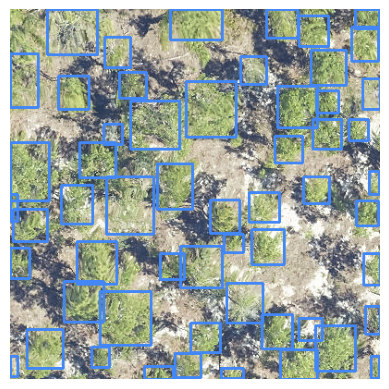

In [3]:
from deepforest import get_data
from deepforest.visualize import plot_results
from deepforest.utilities import read_file

boxes = m.predict_image(path=get_data("OSBS_029.png"))

print(boxes)
plot_results(boxes)

In [4]:
# Load the box dataset
from milliontrees import get_dataset
from milliontrees.common.data_loaders import get_eval_loader

box_dataset = get_dataset("TreeBoxes", root_dir="/orange/ewhite/DeepForest/MillionTrees/")
box_test_data = box_dataset.get_subset("test")

The general workflow is to yield a image, and targets (orange), make a predictions (blue) and evaluate the metric. 

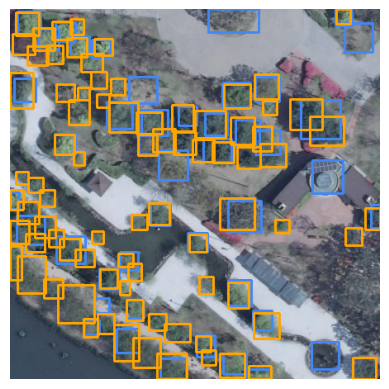

In [5]:
metadata, image, targets = box_test_data[0]
image_path = box_dataset._filename_id_to_code[int(metadata[0])]
image_path = os.path.join(box_dataset._data_dir._str, "images",image_path)

# Load the image, in this case DeepForest expects a numpy array, channels first, 0-255.
channels_first = image.permute(1, 2, 0).numpy() * 255
boxes = m.predict_image(channels_first)
ground_truth = read_file(pd.DataFrame(targets["y"].numpy(),columns=["xmin","ymin","xmax","ymax"]))
ground_truth["label"] = "Tree"
plot_results(boxes, ground_truth, image=channels_first.astype("int32"))

## Evaluation example

Every model will output predictions in a slightly different way. MillionTrees expects a dictionary of tensors, same format between predictions and ground truth.

In [6]:
y_pred = {}
y_pred["y"] = torch.tensor(boxes[["xmin", "ymin", "xmax","ymax"]].values.astype("float32"))
y_pred["labels"] = torch.tensor(boxes.label.apply(
        lambda x: m.label_dict[x]).values.astype(np.int64))
y_pred["scores"] = torch.tensor(boxes.score.values.astype("float32"))

# The eval method takes in batches, so wrap this one example in a list
box_test_data.eval([y_pred], [targets], metadata=torch.unsqueeze(metadata, dim=0))

({'accuracy': {'detection_accuracy_avg': 0.4204545319080353,
   'detection_accuracy_source_id:0': 0.4204545319080353,
   'count_source_id:0': 1.0,
   'detection_accuracy_source_id:1': nan,
   'count_source_id:1': 0.0,
   'detection_accuracy_source_id:2': nan,
   'count_source_id:2': 0.0,
   'detection_accuracy_source_id:3': nan,
   'count_source_id:3': 0.0,
   'detection_accuracy_source_id:4': nan,
   'count_source_id:4': 0.0,
   'detection_accuracy_source_id:5': nan,
   'count_source_id:5': 0.0,
   'detection_accuracy_source_id:6': nan,
   'count_source_id:6': 0.0,
   'detection_accuracy_source_id:7': nan,
   'count_source_id:7': 0.0,
   'detection_accuracy_source_id:8': nan,
   'count_source_id:8': 0.0,
   'detection_accuracy_wg': 0.4204545319080353},
  'recall': {'detection_recall_avg': 0.45679011940956116,
   'detection_recall_source_id:0': 0.45679011940956116,
   'count_source_id:0': 1.0,
   'detection_recall_source_id:1': nan,
   'count_source_id:1': 0.0,
   'detection_recall_sou

The evaluation dictionary is broken down by 'sources' which are individual projects contributed to the MillionTrees project, listed on the 'datasets' page on the docs. For each source the dictionary gives a count of the number of images, and then the bounding box mAP accuracy score. Then it gives the average within-group 'wg' score, and the average over all groups. 

For most evaluation workflows there will be some intermediary code to format the output of whatever prediction workflow to the desired eval format. It would also be nice to have a plotting function to see some examples.

In [7]:
import warnings

def format_deepforest_prediction(images, metadata, targets, m, batch_index):
    # Suppress user warnings to make more readable
    warnings.filterwarnings("ignore")
        
    images = torch.tensor(images)
    predictions = m.predict_step(images, batch_index)
    for image_metadata, pred, image_targets, image in zip(metadata,predictions, targets, images):
        basename = box_dataset._filename_id_to_code[int(image_metadata[0])]
        if pred is None:
            y_pred = {}
            y_pred["y"] = torch.zeros(4)
            y_pred["labels"] = torch.zeros(1)
            y_pred["scores"] = torch.zeros(1)
        else:
            pred.root_dir = os.path.join(box_dataset._data_dir._str, "images")
            pred["image_path"] = basename
            # Reformat to milliontrees format
            y_pred = {}
            y_pred["y"] = torch.tensor(pred[["xmin", "ymin", "xmax","ymax"]].values.astype("float32"))
            y_pred["labels"] = torch.tensor(pred.label)
            y_pred["scores"] = torch.tensor(pred.score.values.astype("float32"))
    
    return y_pred, predictions

# Helper function to plot evaluation results
def plot_eval_results(y_pred, pred, image_targets, image, batch_index):  
    basename = pred.image_path.unique()[0]
    ground_truth = read_file(pd.DataFrame(image_targets["y"].numpy(),columns=["xmin","ymin","xmax","ymax"]))
    ground_truth["label"] = "Tree"
    predictions_df = read_file(pred)
    predictions_df["label"] = "Tree"
    # Make image channel last
    image = image.permute(1, 2, 0).numpy()  * 255
    accuracy = box_dataset.metrics["accuracy"]._accuracy(image_targets["y"], y_pred["y"], iou_threshold=0.3)
    plot_results(predictions_df, ground_truth, image=image.astype("int32"))
    print(f"Image: {basename}, index {batch_index} with Detection Accuracy: {accuracy.item():.2f}")

There are 95 batches in the test loader


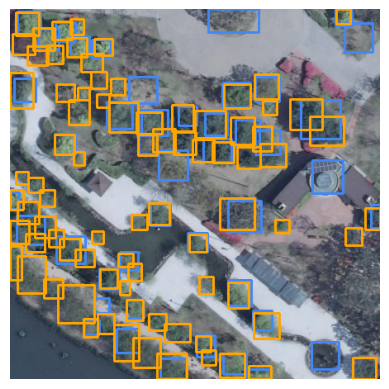

Image: small15.jpg, index 0 with Detection Accuracy: 0.01


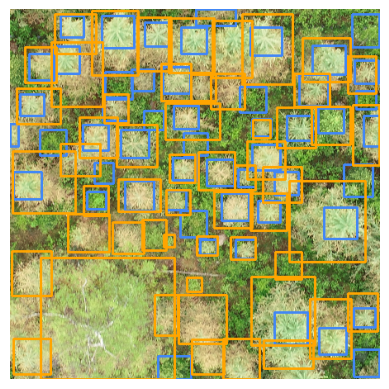

Image: B02_0061.JPG, index 250 with Detection Accuracy: 0.11


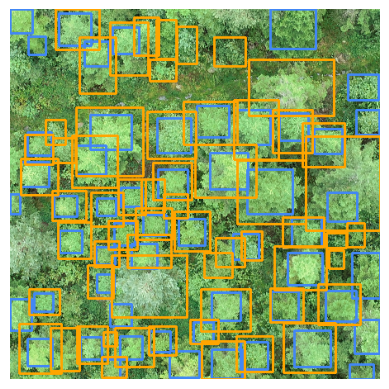

Image: B07_0124.JPG, index 500 with Detection Accuracy: 0.11


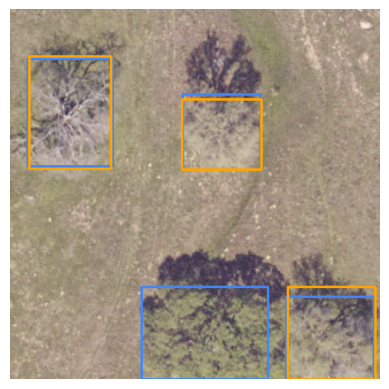

Image: 2018_SJER_3_258000_4106000_image_389.png, index 750 with Detection Accuracy: 0.00


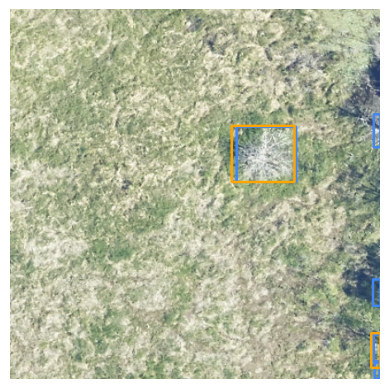

Image: 2019_OSBS_5_405000_3287000_image2_40.png, index 1000 with Detection Accuracy: 0.03


In [ ]:
# Get the test loader
test_loader = get_eval_loader("standard", box_test_data, batch_size=12)

# Print the length of the test loader
print("There are {} batches in the test loader".format(len(test_loader)))

# Get predictions for the full test set
all_y_pred = []
all_y_true = []

batch_index = 0
for batch in test_loader:
    metadata, images, targets  = batch
    # Get the original DeepForest, and MillionTrees formatted predictions
    milliontrees_format, deepforest_format = format_deepforest_prediction(images, metadata, targets, m, batch_index)
    for image_metadata, pred, image_targets, image in zip(metadata, deepforest_format, targets, images):
        # Plot every 250th image
        if batch_index % 250 == 0:
            plot_eval_results(milliontrees_format, pred, image_targets, image, batch_index)
        # Gather all predictions and ground truth
        all_y_pred.extend([y_pred])
        all_y_true.extend([image_targets])
        batch_index += 1

# Evaluate
box_dataset.eval(all_y_pred, all_y_true, box_test_data.metadata_array)